Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating data generators...
Checking training path: /content/drive/MyDrive/DATASET TRAIN
Found 2770 images belonging to 2 classes.
Found 691 images belonging to 2 classes.
Found 2770 images belonging to 2 classes.
Epoch 1/20
174/174 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.6101 - precision_1: 0.6101 - recall_1: 0.6101
Epoch 1: val_accuracy improved from -inf to 0.75832, saving model to nutrition_model-001-0.7583.keras
174/174 [==============================] - 481s 3s/step - loss: 0.6503 - accuracy: 0.6101 - precision_1: 0.6101 - recall_1: 0.6101 - val_loss: 0.5799 - val_accuracy: 0.7583 - val_precision_1: 0.7583 - val_recall_1: 0.7583 - lr: 1.0000e-04
Epoch 2/20
174/174 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.7422 - precision_1: 0.7422 - recall_1: 0.7422
Epoch 2: val_accuracy improved from 0.7583

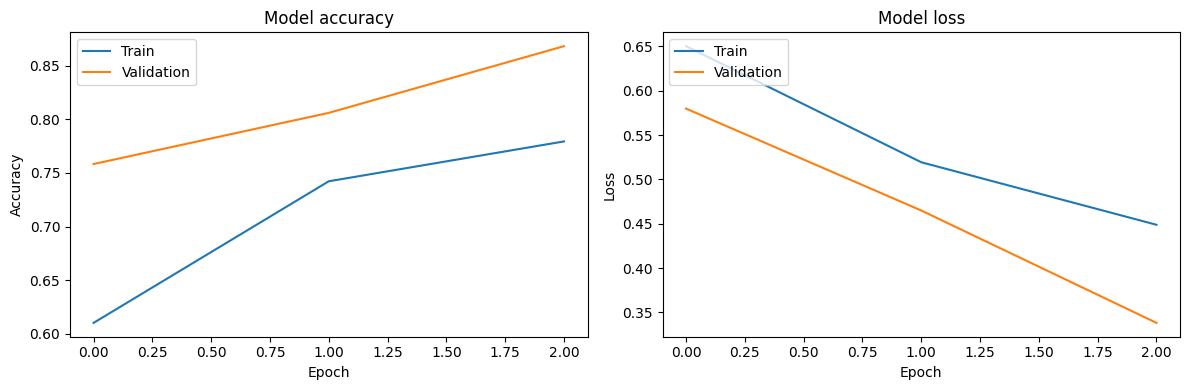

44/44 [==============================] - 124s 3s/step - loss: 0.3318 - accuracy: 0.8654 - precision_1: 0.8654 - recall_1: 0.8654
Validation Loss: 0.3318, Validation Accuracy: 0.8654, Validation Precision: 0.8654, Validation Recall: 0.8654
44/44 [==============================] - 125s 3s/step


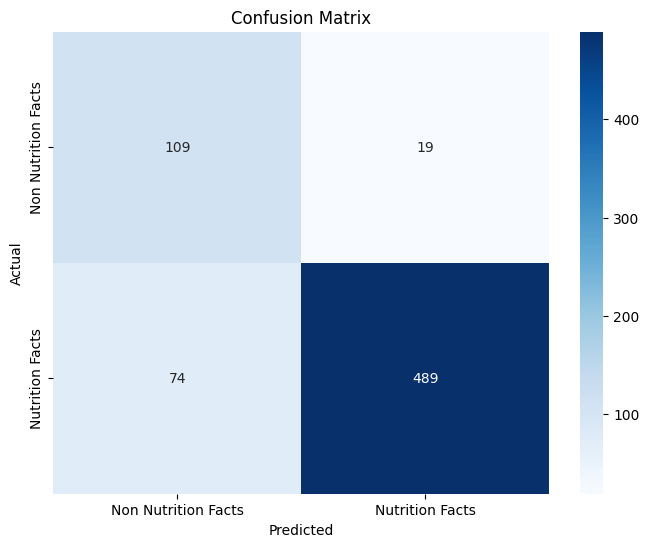

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_CLASSES = 2
train_path = '/content/drive/MyDrive/DATASET TRAIN'

# Define AccuracyThresholdCallback class
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('val_accuracy') is not None:
            if logs.get('val_accuracy') >= self.threshold:
                print(f"\nStopping training as validation accuracy has reached {self.threshold:.2f}.")
                self.model.stop_training = True

def create_data_generators():
    print("Creating data generators...")
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[0.7, 1.3],
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    print(f"Checking training path: {train_path}")
    if not os.path.exists(train_path):
        raise ValueError(f"Training path not found: {train_path}")

    try:
        # Original data generators
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        validation_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        # Oversampling for minority class
        class_counts = train_generator.classes
        unique_classes, counts = np.unique(class_counts, return_counts=True)
        max_count = max(counts)

        oversampled_indexes = []
        for cls in unique_classes:
            cls_indexes = np.where(class_counts == cls)[0]
            oversampled_indexes.extend(np.random.choice(cls_indexes, max_count, replace=True))

        # Shuffle the oversampled indexes
        np.random.shuffle(oversampled_indexes)

        # Create new generator with oversampled data
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        return train_generator, validation_generator

    except Exception as e:
        print(f"Error creating generators: {str(e)}")
        return None, None

def create_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Create data generators
train_generator, validation_generator = create_data_generators()

if train_generator is not None and validation_generator is not None:
    # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Create and train model
    model = create_cnn_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    tensorboard_callback = TensorBoard(log_dir='./logs')

    checkpoint = ModelCheckpoint(
        'nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    accuracy_threshold_callback = AccuracyThresholdCallback(threshold=0.85)

    # Train model with class weights
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[
            checkpoint,
            early_stopping,
            reduce_lr,
            tensorboard_callback,
            accuracy_threshold_callback
        ],
    )
else:
    print("\nError: Train generator or validation generator is None. Please check the data preparation step.")

# Plotting training history
plot_training_history(history)

# Save the trained model
model.save('nutrition_model_cnn.keras')

# Evaluate the model on validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Nutrition Facts', 'Nutrition Facts'], yticklabels=['Non Nutrition Facts', 'Nutrition Facts'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Fungsi deteksi nutrisi
def detect_nutrition_facts(image_path, model):
    """Fungsi deteksi dengan preprocessing yang lebih baik"""
    img = cv2.imread(image_path)
    if img is None:
        return None, 0.0, None

    img_orig = img.copy()

    # Preprocessing yang lebih baik
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)
    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        2
    )

    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area_ratio = (w * h) / (img.shape[0] * img .shape[1])

            if 0.4 <= aspect_ratio <= 2.5 and 0.05 <= area_ratio <= 0.9:
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        prediction = model.predict(result)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'

        return img_orig, confidence, predicted_class, nutrition_box

    return img_orig, 0.0, None, None


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating data generators...
Checking training path: /content/drive/MyDrive/DATASET TRAIN
Found 2770 images belonging to 2 classes.
Found 691 images belonging to 2 classes.
Found 2770 images belonging to 2 classes.
Epoch 1/20
174/174 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5888 - precision: 0.5888 - recall: 0.5888
Epoch 1: val_accuracy improved from -inf to 0.72069, saving model to nutrition_model-001-0.7207.keras
174/174 [==============================] - 622s 4s/step - loss: 0.6833 - accuracy: 0.5888 - precision: 0.5888 - recall: 0.5888 - val_loss: 0.5628 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 0.7207 - lr: 1.0000e-04
Epoch 2/20
174/174 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.7921 - precision: 0.7921 - recall: 0.7921
Epoch 2: val_accuracy improved from 0.72069 to 0.79305, sa

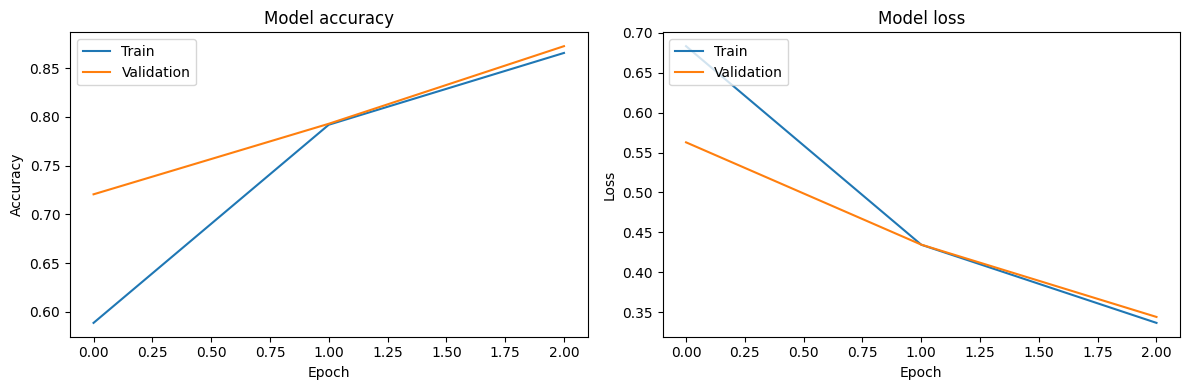

44/44 [==============================] - 131s 3s/step - loss: 0.3528 - accuracy: 0.8669 - precision: 0.8669 - recall: 0.8669
Validation Loss: 0.3528, Validation Accuracy: 0.8669, Validation Precision: 0.8669, Validation Recall: 0.8669
44/44 [==============================] - 132s 3s/step


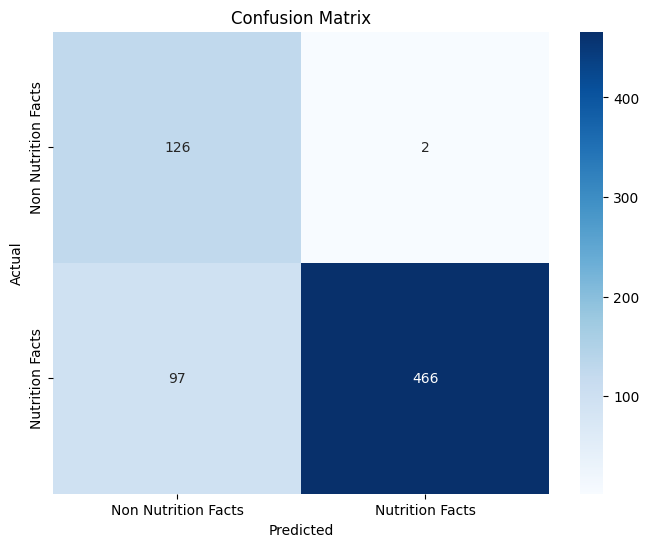

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_CLASSES = 2
train_path = '/content/drive/MyDrive/DATASET TRAIN'

# Define AccuracyThresholdCallback class
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('val_accuracy') is not None:
            if logs.get('val_accuracy') >= self.threshold:
                print(f"\nStopping training as validation accuracy has reached {self.threshold:.2f}.")
                self.model.stop_training = True

def create_data_generators():
    print("Creating data generators...")
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[0.7, 1.3],
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    print(f"Checking training path: {train_path}")
    if not os.path.exists(train_path):
        raise ValueError(f"Training path not found: {train_path}")

    try:
        # Original data generators
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        validation_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        # Oversampling for minority class
        class_counts = train_generator.classes
        unique_classes, counts = np.unique(class_counts, return_counts=True)
        max_count = max(counts)

        oversampled_indexes = []
        for cls in unique_classes:
            cls_indexes = np.where(class_counts == cls)[0]
            oversampled_indexes.extend(np.random.choice(cls_indexes, max_count, replace=True))

        # Shuffle the oversampled indexes
        np.random.shuffle(oversampled_indexes)

        # Create new generator with oversampled data
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        return train_generator, validation_generator

    except Exception as e:
        print(f"Error creating generators: {str(e)}")
        return None, None

def create_transfer_learning_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Create data generators
train_generator, validation_generator = create_data_generators()

if train_generator is not None and validation_generator is not None:
    # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Create and train model
    model = create_transfer_learning_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    tensorboard_callback = TensorBoard(log_dir='./logs')

    checkpoint = ModelCheckpoint(
        'nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    accuracy_threshold_callback = AccuracyThresholdCallback(threshold=0.85)

    # Train model with class weights
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[
            checkpoint,
            early_stopping,
            reduce_lr,
            tensorboard_callback,
            accuracy_threshold_callback
        ],
    )
else:
    print("\nError: Train generator or validation generator is None. Please check the data preparation step.")

# Plotting training history
plot_training_history(history)

# Save the trained model
model.save('nutrition_model_improved_transfer_learning.keras')

# Evaluate the model on validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Nutrition Facts', 'Nutrition Facts'], yticklabels=['Non Nutrition Facts', 'Nutrition Facts'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Fungsi deteksi nutrisi
def detect_nutrition_facts(image_path, model):
    """Fungsi deteksi dengan preprocessing yang lebih baik"""
    img = cv2.imread(image_path)
    if img is None:
        return None, 0.0, None

    img_orig = img.copy()

    # Preprocessing yang lebih baik
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)
    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        2
    )

    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area_ratio = (w * h) / (img.shape[0] * img .shape[1])

            if 0.4 <= aspect_ratio <= 2.5 and 0.05 <= area_ratio <= 0.9:
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        prediction = model.predict(result)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'

        return img_orig, confidence, predicted_class, nutrition_box

    return img_orig, 0.0, None, None


In [ ]:
loaded_model = tf.keras.models.load_model('/content/nutrition_model_cnn.keras')

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170945_494 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170945_494 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170936_730 (1).jpg
1/1 [==============================] - 0s 90ms/step


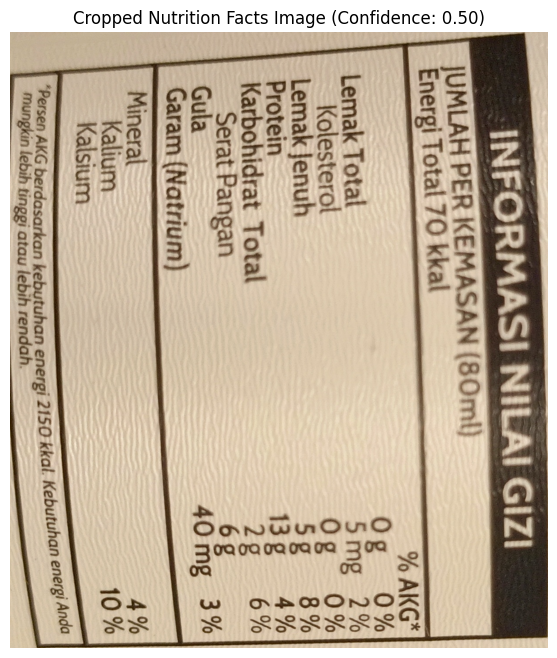

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170917_811 (1).jpg
1/1 [==============================] - 0s 40ms/step


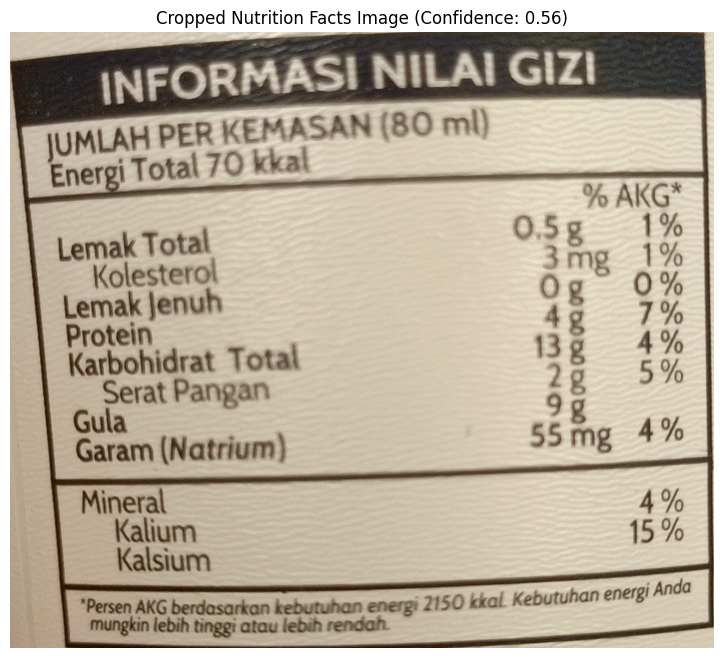

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170857_845 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170857_845 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170836_204 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170836_204 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170823_579 (1).jpg
1/1 [==============================] - 0s 38ms/step


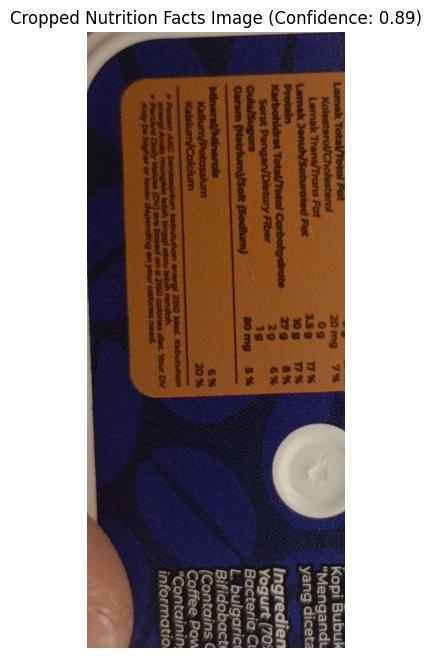

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170822309_BURST0001_COVER (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_170822309_BURST0001_COVER (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732281071917 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732281071917 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732281017212 (1).jpg
1/1 [==============================] - 0s 39ms/step


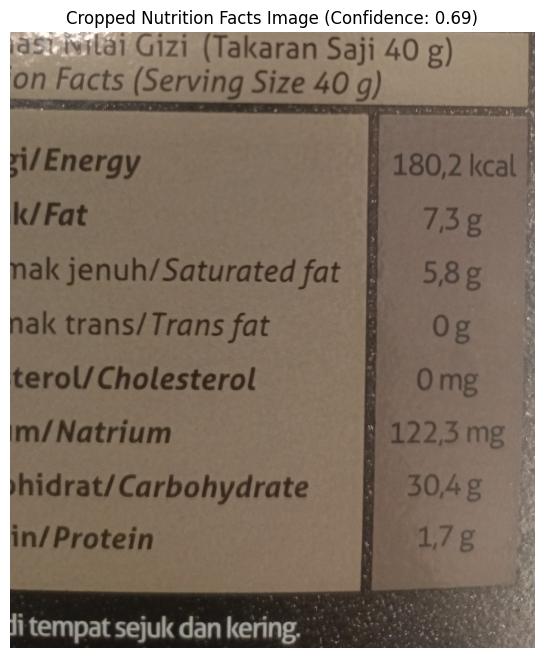

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280997773 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280997773 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280947278 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280947278 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280888697 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280888697 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280752874 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280752874 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280679062 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DA

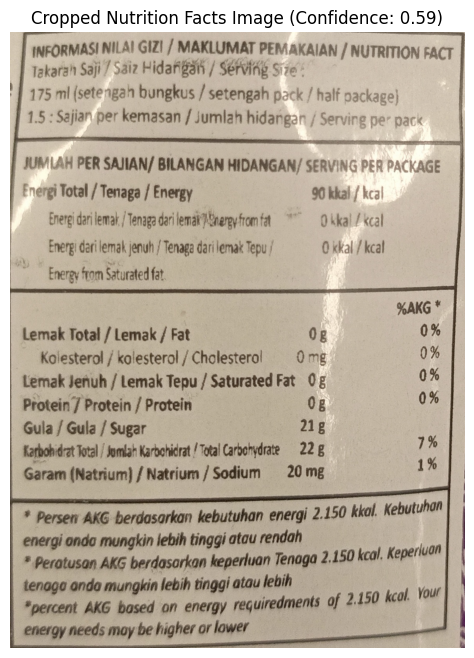

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280611924 (1).jpg
1/1 [==============================] - 0s 39ms/step


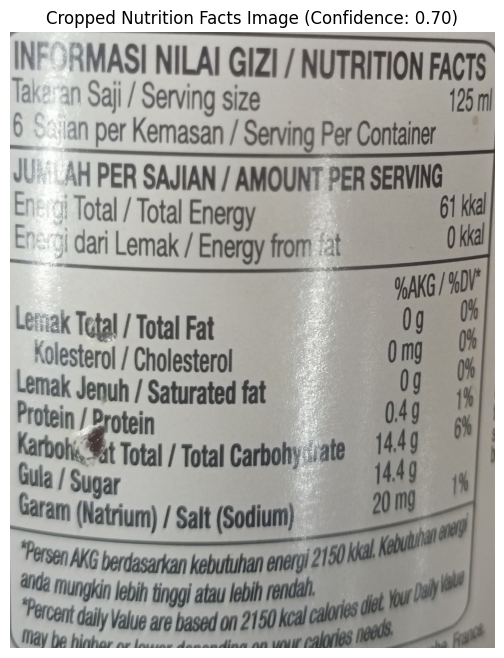

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280570758 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280570758 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280544988 (1).jpg
1/1 [==============================] - 0s 39ms/step


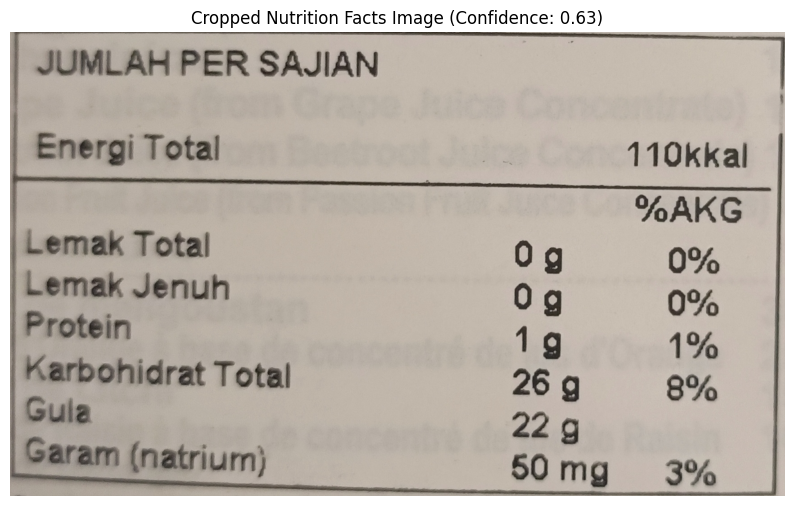

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280506332 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280506332 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280455477 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280455477 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280420495 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280420495 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280381157 (1).jpg
1/1 [==============================] - 0s 39ms/step


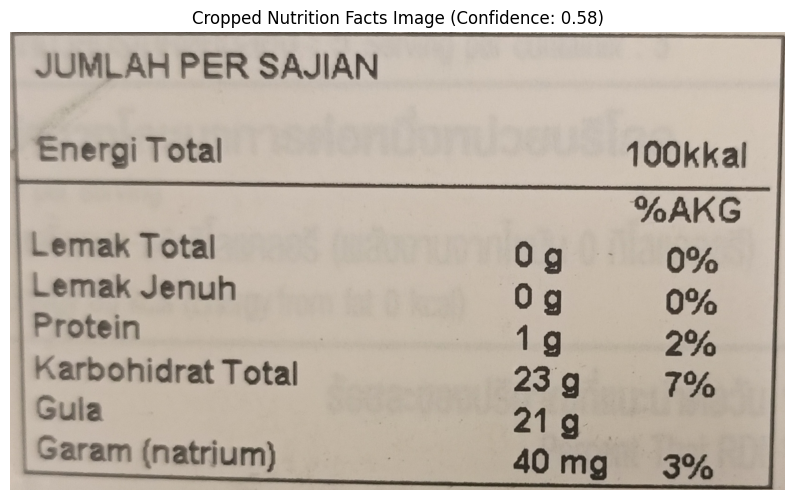

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280332942 (1).jpg
1/1 [==============================] - 0s 39ms/step


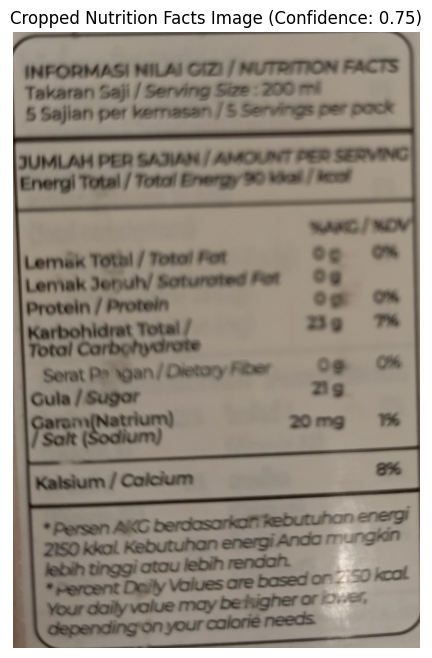

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280303183 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280303183 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280284298 (1).jpg
1/1 [==============================] - 0s 40ms/step


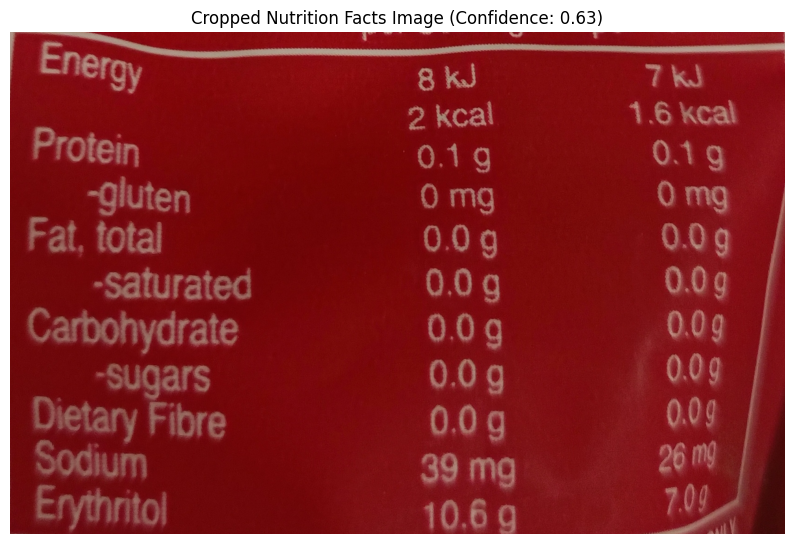

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280255774 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280255774 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280229808 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280229808 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280186859 (1).jpg
1/1 [==============================] - 0s 38ms/step


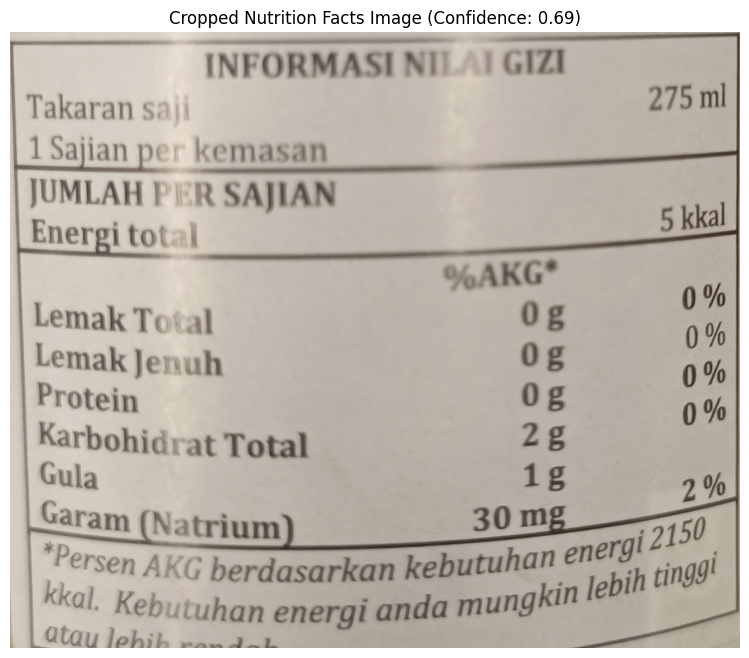

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280167383 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280167383 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280087946 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280087946 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280043852 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280043852 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280012337 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732280012337 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279982443.jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASE

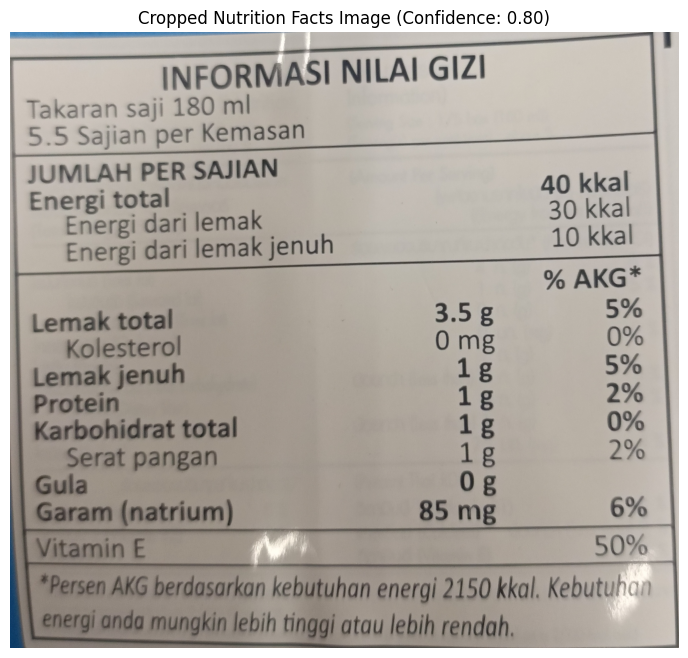

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279887677 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279887677 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279810019 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279810019 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279780697 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279780697 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279757955 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279757955 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279740933 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DA

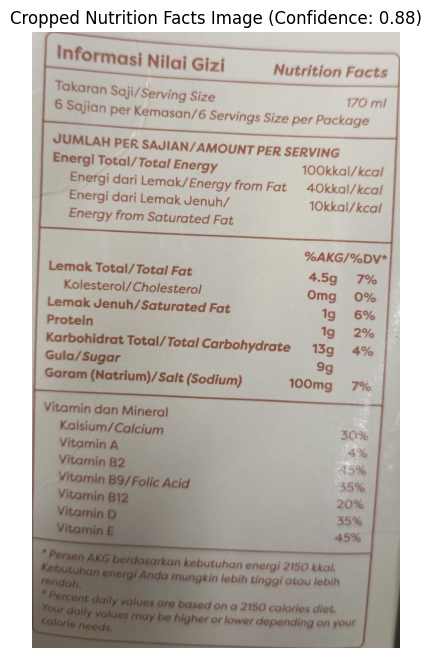

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279667834 (1).jpg
1/1 [==============================] - 0s 43ms/step


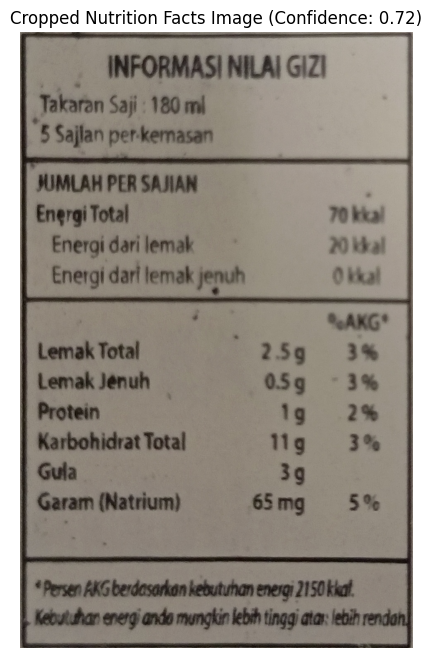

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279641197 (1).jpg
1/1 [==============================] - 0s 41ms/step


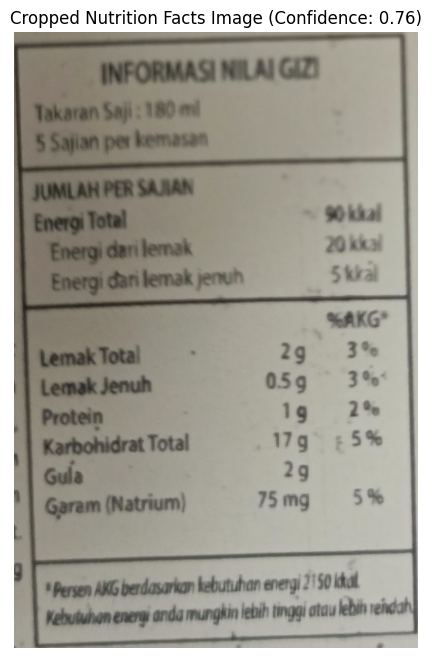

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279615389 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279615389 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279561464 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279561464 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279517360 (2).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279517360 (2).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279462752 (1).jpg
1/1 [==============================] - 0s 41ms/step


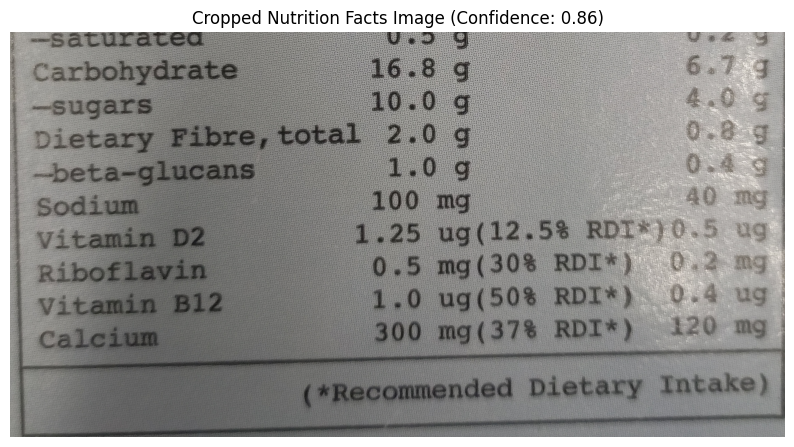

Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279445593 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279445593 (1).jpg
Processing image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279428443 (1).jpg
No nutrition facts detected in the image: /content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/1732279428443 (1).jpg


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Fungsi untuk memotong gambar berdasarkan kontur
def crop_nutrition_facts(image_path, contour):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image could not be loaded for {image_path}.")
        return None

    # Crop berdasarkan bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cropped_image = img[y:y+h, x:x+w]

    return cropped_image

# Path folder dengan gambar-gambar
test_image_folder = "/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts"

if os.path.exists(test_image_folder):
    # Ambil hingga 10 gambar dari folder
    image_files = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:50]

    if len(image_files) == 0:
        print("No images found in the folder.")
    else:
        for image_path in image_files:
            print(f"Processing image: {image_path}")

            # Deteksi dan potong gambar menggunakan model
            result_image, confidence, predicted_class, contour = detect_nutrition_facts(image_path, loaded_model)

            if contour is not None:
                cropped_image = crop_nutrition_facts(image_path, contour)

                # Tampilkan gambar yang dipotong
                if cropped_image is not None:
                    plt.figure(figsize=(10, 8))
                    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                    plt.title(f'Cropped Nutrition Facts Image (Confidence: {confidence:.2f})')
                    plt.axis('off')
                    plt.show()
            else:
                print(f"No nutrition facts detected in the image: {image_path}")
else:
    print(f"Error: The folder does not exist at the specified path: {test_image_folder}")
